In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#Act = pd.read_csv("atusact_0323.dat")
Resp=pd.read_csv("atusresp_0323.dat")
Raster=pd.read_csv("atusrost_0323.dat")

In [6]:
Resp.columns.unique()

Index(['TUCASEID', 'TULINENO', 'TESPUHRS', 'TRDTIND1', 'TRDTOCC1', 'TRERNHLY',
       'TRERNUPD', 'TRHERNAL', 'TRHHCHILD', 'TRIMIND1',
       ...
       'TRWBMODR', 'TRTALONE_WK', 'TRTCCC_WK', 'TRLVMODR', 'TRTEC', 'TUECYTD',
       'TUELDER', 'TUELFREQ', 'TUELNUM', 'TU20FWGT'],
      dtype='object', length=133)

In [7]:
#TRSPPRES. Presence of the respondent's spouse or unmarried partner in the household. This variable appears on the Respondent File and the Activity Summary File.
#TELFS labor status 
#TEHRUSL1:Usual weekly hours at the main job, since more working hours could reduce free time available to spend alone.
#TRTFAMILY (Respondent File): Total time spent with family members,
respondent_vars = ['TUCASEID', 'TRTALONE', 'TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1', 'TRTHH', 'TRTFAMILY']
roster_vars = ['TUCASEID', 'TEAGE', 'TESEX']

### Information about TELFS

The variable **TELFS** (Labor Force Status) is found in the **Respondent File** and the **Activity Summary File** and applies to all respondents. The valid entries for **TELFS** are:

*   1 Employed - at work 
*   2 Employed - absent 
*   3 Unemployed - on layoff
*   4 Unemployed - looking 
*   5 Not in labor force 

**TELFS** is used to define the **edited universe** for several other variables.  The edited universe identifies the group of survey respondents for whom a variable is defined. For example, **TEIO1OCD** (occupation code for the respondent's main job) is only defined for respondents who are employed.  So the edited universe for **TEIO1OCD** is **TELFS = 1 or 2.** 

The sources also provide examples illustrating how **TELFS** is used in a simplified version of the **Respondent File**. The simplified file contains five respondents, each with a corresponding **TELFS** value. For example, one respondent has a **TELFS** value of 5, indicating they are not in the labor force. 


In [8]:
# Subset the data to the variables of interest
respondent_subset = Resp[respondent_vars]
roster_subset = Raster[roster_vars]

In [9]:
# Merge the files on the ID column
merged_df = pd.merge(respondent_subset, roster_subset, on='TUCASEID', how='inner')

In [10]:
# I am investigating only for the adults 
adults_df = merged_df[merged_df['TEAGE'] >= 18]

In [11]:
sampled_df = adults_df.sample(n=1000, random_state=42)  # random_state for reproducibility


In [12]:
final_df = sampled_df.drop_duplicates(subset='TUCASEID')


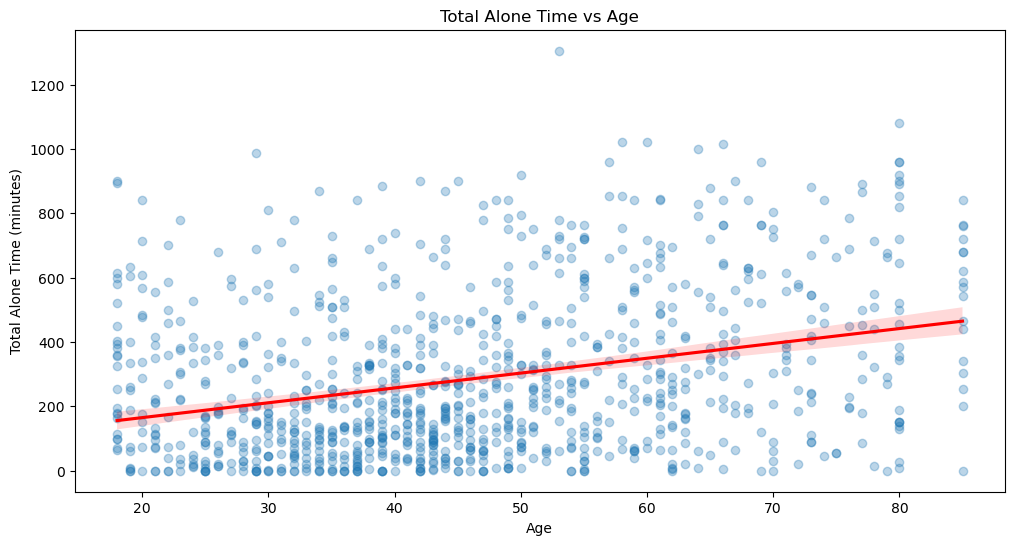

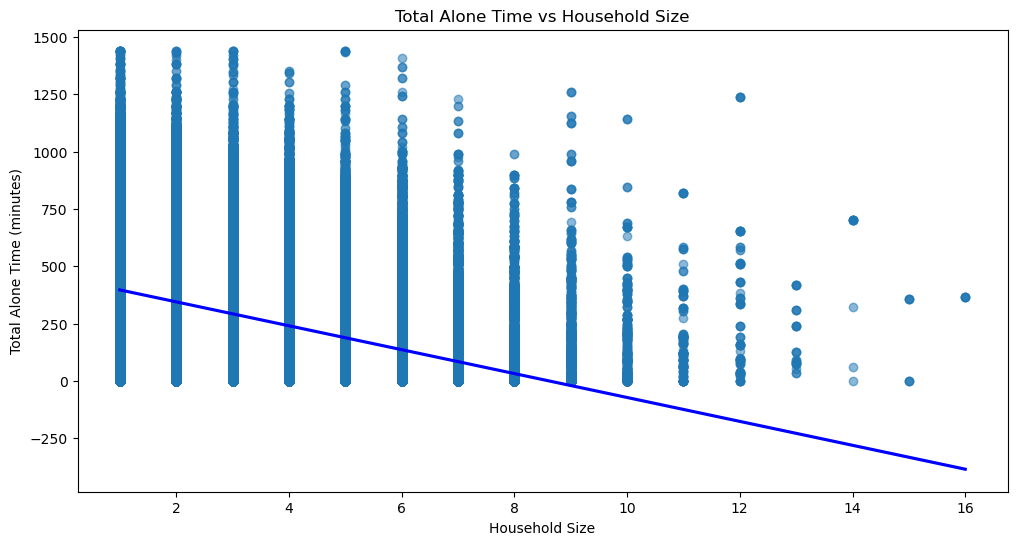

In [13]:
plt.figure(figsize=(12, 6))

# Plot total alone time vs age with regression line
sns.regplot(data=final_df, x='TEAGE', y='TRTALONE', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Total Alone Time vs Age')
plt.xlabel('Age')
plt.ylabel('Total Alone Time (minutes)')
plt.show()

# Plot total alone time vs household size with regression line
plt.figure(figsize=(12, 6))
sns.regplot(data=adults_df, x='TRNUMHOU', y='TRTALONE', scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
plt.title('Total Alone Time vs Household Size')
plt.xlabel('Household Size')
plt.ylabel('Total Alone Time (minutes)')
plt.show()

#log 

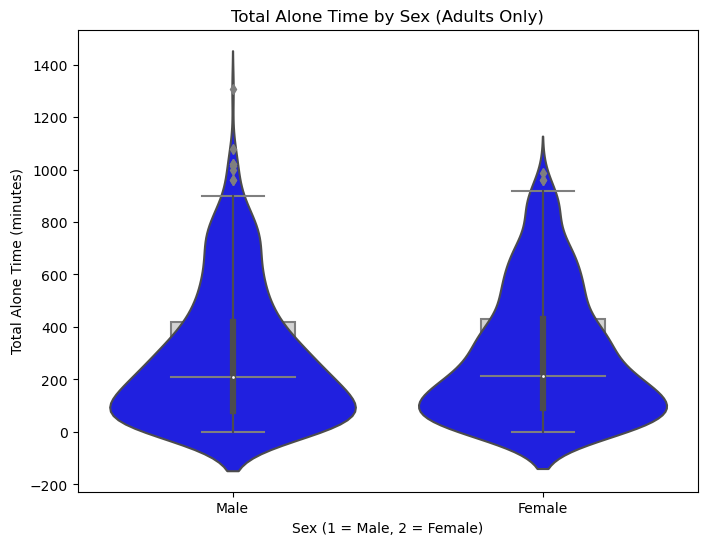

In [14]:
# Set up the boxplot for TRTALONE by TESEX
plt.figure(figsize=(8, 6))

# Create a boxplot
sns.boxplot(data=final_df, x='TESEX', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TESEX', y='TRTALONE', color='blue', alpha=0.5)

# Customizing the plot
plt.title('Total Alone Time by Sex (Adults Only)')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks([0, 1], ['Male', 'Female'])  # Setting labels for clarity

plt.show()

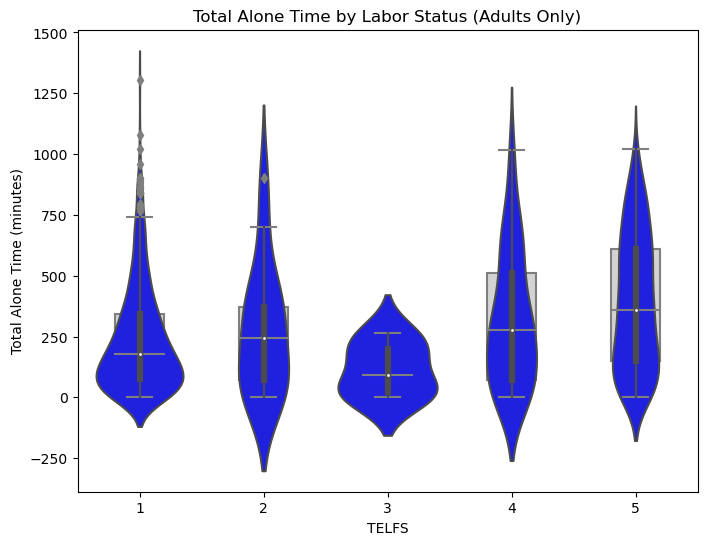

In [15]:
plt.figure(figsize=(8, 6))

# Create a boxplot
sns.boxplot(data=final_df, x='TELFS', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TELFS', y='TRTALONE', color='blue', alpha=0.5)

# Customizing the plot
plt.title('Total Alone Time by Labor Status (Adults Only)')
plt.ylabel('Total Alone Time (minutes)')  # Setting labels for clarity

plt.show()

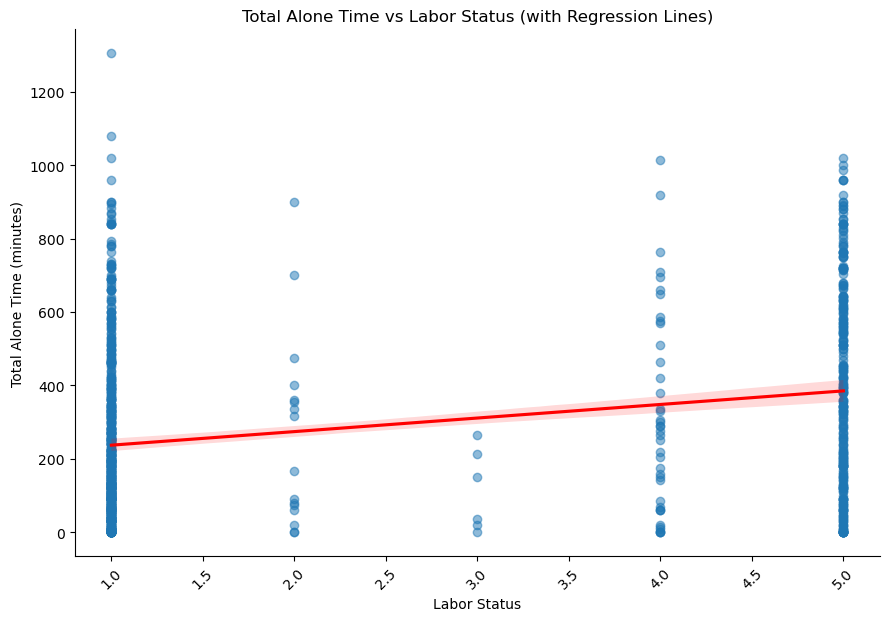

In [16]:
sns.lmplot(data=final_df, x='TELFS', y='TRTALONE', 
           aspect=1.5, height=6, 
           palette='Set1', 
           markers='o', 
           scatter_kws={'alpha':0.5}, 
           line_kws={'color':'red'})

plt.title('Total Alone Time vs Labor Status (with Regression Lines)')
plt.ylabel('Total Alone Time (minutes)')
plt.xlabel('Labor Status')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.show()